# Hands-on CURVE

Acknowledgements: [Stefan Oehmcke](https://stefoe.github.io/) for the code used in this notebook.

This notebook will guide you through a data preprocessing pipeline implementing the CURVE framework you heard about in the lecture.

- CURVE: Clean – Unite – Record – Validate – Export
- Dataset: Our World in Data (OWID) CO2 + Energy (open, no API key)
- Question: Is a higher low-carbon electricity share associated with lower CO2 per capita (2000–2024)?

For all included code, think "What is this doing and why should we do this here?".

## Before we start: Configuration

We recommend placing import statements as well as variables configuring high-level behaviour at the top of your notebooks.

In [11]:
import pandas as pd
import numpy as np
from datetime import date
import platform
import matplotlib.pyplot as plt

YEARS = (2000, 2024)
MISSING_POLICY = "drop"         # options: "drop" | "interpolate"
INTERP_LIMIT = 2                # max consecutive years to fill when interpolating
EXPORT_BASENAME = f"owid_co2_energy_ready_{date.today().isoformat()}"

CO2_URL    = "https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv"
ENERGY_URL = "https://raw.githubusercontent.com/owid/energy-data/master/owid-energy-data.csv"

# C = Clean (load + tidy columns + filter countries/years)

In [12]:
co2_raw = pd.read_csv(CO2_URL)
energy_raw = pd.read_csv(ENERGY_URL)

co2_keep = ["iso_code", "country", "year", "co2_per_capita", "co2"]  # co2 = total Mt (optional)
co2 = co2_raw[co2_keep].copy()

# Ensure year numeric and drop rows missing iso_code/year early
co2["year"] = pd.to_numeric(co2["year"], errors="coerce")
co2 = co2.dropna(subset=["iso_code", "year"]).assign(year=lambda d: d["year"].astype(int))

# Prefer low_carbon_electricity_share; fall back to renewables_share_elec if needed
cands = [c for c in energy_raw.columns if "low_carbon_electricity_share" in c] \
        or [c for c in energy_raw.columns if "renewables_share_elec" in c]
share_col = cands[0]

energy_keep = ["iso_code", "country", "year", share_col, "electricity_demand", "population", "gdp"]
energy = energy_raw[energy_keep].copy()

energy["year"] = pd.to_numeric(energy["year"], errors="coerce")
energy = energy.dropna(subset=["iso_code", "year"]).assign(year=lambda d: d["year"].astype(int))

# Keep only countries (OWID convention: 3-letter ISO codes are countries; others are aggregates)
co2    = co2[co2["iso_code"].astype(str).str.len() == 3]
energy = energy[energy["iso_code"].astype(str).str.len() == 3]

# Year window
co2    = co2.query(f"{YEARS[0]} <= year <= {YEARS[1]}")
energy = energy.query(f"{YEARS[0]} <= year <= {YEARS[1]}")

# U = UNITE (inner-join by iso_code + year)

Implement an inner join between the co2 and energy data, matching the ISO code, country and year values.

In [14]:
# TODO
df = None

In [16]:
df = df.rename(columns={share_col: "low_carbon_elec_share"})

# R = RECORD (note decisions in comments)

- What are the data sources?
- What major decisions on how to handle the data have been taken?
  - Was any data removed?
  - Were data types changed?
  - Were columns/rows/cells merged or split?

# V = VALIDATE

## Handling missing data

Add the code path where missing data is being dropped.

In [17]:
req_cols = ["co2_per_capita", "low_carbon_elec_share"]

# Missing data policy: DROP vs INTERPOLATE
if MISSING_POLICY == "drop":
    # TODO
    pass
elif MISSING_POLICY == "interpolate":
    # Interpolate within each country over time (linear), up to INTERP_LIMIT consecutive years
    df = df.sort_values(["iso_code", "year"])
    def _interp_country(g):
        g = g.copy()
        for c in req_cols:
            g[c] = g[c].interpolate(method="linear", limit=INTERP_LIMIT, limit_direction="both")
        # optional: clamp to valid share range after interpolation
        if c == "low_carbon_elec_share":
            g["low_carbon_elec_share"] = g["low_carbon_elec_share"].clip(lower=0, upper=100)
        return g
    na_before = df[req_cols].isna().sum().sum()
    df = df.groupby("iso_code", group_keys=False).apply(_interp_country)
    na_after = df[req_cols].isna().sum().sum()
    print(f"[Missing policy: INTERPOLATE] NA cells before: {na_before}  after: {na_after}")
    # If some NAs remain (long gaps), drop them so validation is simple for students.
    if na_after > 0:
        rows_before = len(df)
        df = df.dropna(subset=req_cols)
        print(f"Remaining NA rows removed after interpolation: {rows_before - len(df)}")
    print("Comment: OK for short, smooth gaps; document the assumption. Avoid long-gap fills or extrapolation.")
else:
    raise ValueError("MISSING_POLICY must be 'drop' or 'interpolate'.")

## Check essential properties (Plain asserts for readability)

- Implement an assertion, that checks that there are no repeated ISO codes or years.
- Implement an assertion, that checks that all values in `low_carbon_elec_share` are within the interval [0,100].

In [19]:
# 1) Keys unique per (iso_code, year)
# TODO

# 2) Required fields not NA
assert ~df[req_cols].isna().any().any(), "Missing values remain in required columns."

# 3) Value ranges
assert (df["co2_per_capita"] >= 0).all(), "Negative CO2 per capita values detected."
# TODO

# 4) Optional plausibility cap (very high extremes rarely occur)
assert df.loc[(df["co2_per_capita"] > 80) | (df["low_carbon_elec_share"] > 100)].empty, "Implausible extremes present."

print("Validation passed ✅")

Validation passed ✅


## Quick sanity outputs

Countries: 201 | Rows: 4758 | Years: [2000–2023]
Pearson corr(co2_per_capita, low_carbon_elec_share) = -0.068


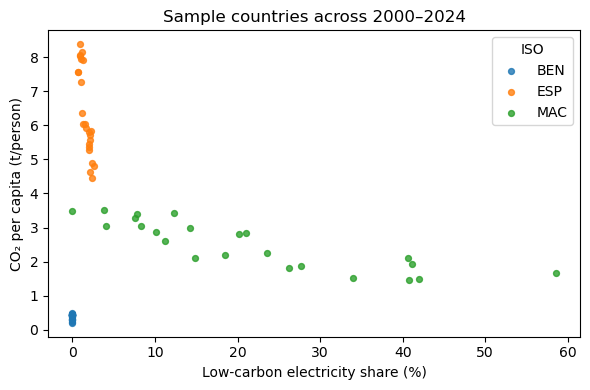

In [21]:
n_countries = df["iso_code"].nunique()
n_rows = len(df)
print(f"Countries: {n_countries} | Rows: {n_rows} | Years: [{df['year'].min()}–{df['year'].max()}]")

# Simple correlation (pooled; not causal)
corr = df[["co2_per_capita", "low_carbon_elec_share"]].corr().iloc[0,1]
print(f"Pearson corr(co2_per_capita, low_carbon_elec_share) = {corr:.3f}")

# Tiny scatter for a feel (random 3 countries)
sample_c = df["iso_code"].drop_duplicates().sample(n=min(3, n_countries), random_state=0).tolist()
sub = df[df["iso_code"].isin(sample_c)]
plt.figure(figsize=(6,4))
for c in sample_c:
    cc = sub[sub["iso_code"]==c]
    plt.scatter(cc["low_carbon_elec_share"], cc["co2_per_capita"], label=c, s=18, alpha=0.8)
plt.xlabel("Low-carbon electricity share (%)")
plt.ylabel("CO₂ per capita (t/person)")
plt.title("Sample countries across 2000–2024")
plt.legend(title="ISO")
plt.tight_layout()
plt.show()

# E = EXPORT (freeze)

Save the contents of `df` in CSV format without the index.

## Reproduction notes (helpful printout)

- Print version information for your installation of Python as well as used packages.
- Print configuration values.
- Print column names, that you saved in the previous step.